#**Overview:**

First attempt at training a Vit model on a subset of the data. The model seems to overfit achieving close to 100% accuracy on training data, while not performing better than random guessing on the validation data.
To deal with this problem the following steps were taken in a different notebook (Vit_ModelTraining.ipynb):
1.More data
2.data augmantion using Image transformations
3.weight decay and label smoothing
4.Focusing only on positive and negative labels (0,1)

###Importing necessary packages and libraries

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report, confusion_matrix
from sklearn.utils import resample
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from transformers import ViTForImageClassification, AdamW

In [ ]:
from IPython.display import Audio

def beep():
  return  Audio(0.00025 * np.sin(2 * np.pi * 220 * np.linspace(0, 0.15, int(44100 * 0.15), endpoint=False)),rate=44100, autoplay=True)

###Loading data and images from google drive

In [ ]:
#load dataframe
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Dissertation/pneumonia_imgs_full.csv')

Mounted at /content/drive


In [ ]:
#load images
with open('/content/drive/My Drive/Dissertation/Images/image_list_full256.pkl', 'rb') as f:
    images = pickle.load(f)

#making sure the number of images matches the dataframe
assert len(images) == len(df)

In [ ]:
#saving image arrays to a new column in the dataframe
df['image'] = images

print(df['image'][0].shape)

(256, 256)


In [ ]:
df.head()

,study_id,dicom_id,subject_id,ViewPosition,img_path,pneumonia,image
0,50666068,116f3a27-3fcec414-3864f913-a6e4c6fe-54b07918,17000103,PA,files/p17/p17000103/s50666068/116f3a27-3fcec41...,1.0,"[[154, 161, 182, 193, 191, 195, 205, 197, 192,..."
1,51540539,6c4ebb06-a2d96f2b-c2502de2-89cf4c0d-064b6f50,17000103,PA,files/p17/p17000103/s51540539/6c4ebb06-a2d96f2...,1.0,"[[142, 127, 120, 109, 101, 107, 108, 112, 114,..."
2,52381151,27e7d231-59bfd5c3-66e1eda4-ca0d0a8b-8ffacb23,17000103,PA,files/p17/p17000103/s52381151/27e7d231-59bfd5c...,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2,..."
3,53838716,07e9a0b4-52559819-ede26703-11403ead-a9b761d5,17000103,PA,files/p17/p17000103/s53838716/07e9a0b4-5255981...,0.0,"[[4, 3, 3, 3, 3, 2, 1, 3, 2, 2, 2, 3, 2, 1, 5,..."
4,57516335,9fcd01ee-d83d9bba-5692b6a5-572b320c-50bedf5c,17000103,AP,files/p17/p17000103/s57516335/9fcd01ee-d83d9bb...,-1.0,"[[8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8,..."


In [ ]:
# resizing images to 224x224 to fit the transformer model
import cv2
images = df['image']
img = []
for image in images:
  img.append(cv2.resize(image, (224,224)))

df['image'] = img

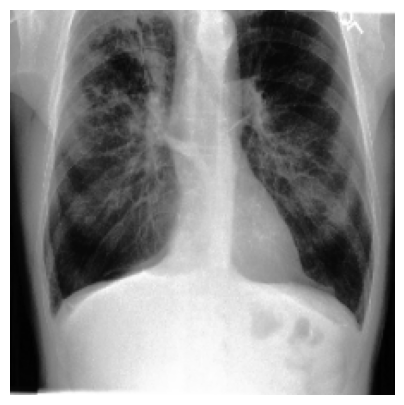

In [ ]:
image = df['image'][0]

image = np.stack((image,)*3, axis=2)
fig, ax  = plt.subplots(figsize = (5,5))
ax.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
#removing non relevant columns from the dataframe
#study id is kept for error analysis
# View position should be kept when looking at AP+PA data
df = df.drop(['dicom_id','subject_id','ViewPosition','img_path'],axis = 1)

In [ ]:
df.head()

,study_id,pneumonia,image
0,50666068,1.0,"[[154, 165, 185, 192, 194, 202, 197, 193, 202,..."
1,51540539,1.0,"[[141, 127, 118, 107, 106, 109, 112, 114, 115,..."
2,52381151,1.0,"[[0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2,..."
3,53838716,0.0,"[[4, 3, 3, 3, 2, 1, 3, 2, 2, 2, 2, 1, 4, 3, 2,..."
4,57516335,-1.0,"[[8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8,..."


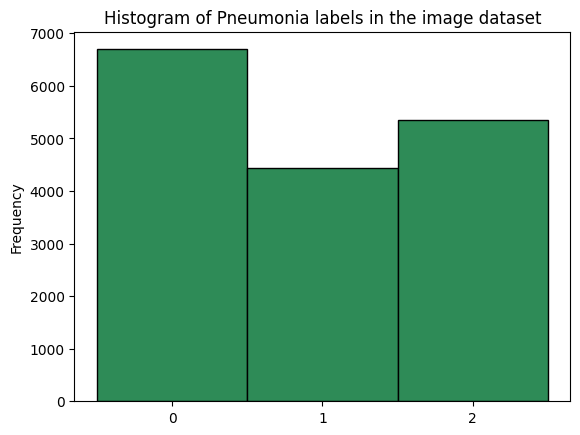

In [ ]:
#converting labels to integers 0,1,2
labels = [label for label in df['pneumonia']]
for i in range(len(labels)):
  if labels[i]==-1:
    labels[i]=2
df['pneumonia'] = [int(label) for label in labels]


plt.hist(df['pneumonia'], bins=[-0.5,0.5, 1.5,2.5], color = 'seagreen',edgecolor='black', align='mid')

plt.title('Histogram of Pneumonia labels in the image dataset')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2])
plt.show()

In [ ]:
# Load the pre-trained Vision Transformer model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=3)

# # Adjust the model to work with grayscale images (1 channel instead of 3)
# model.vit.embeddings.patch_embeddings.projection = torch.nn.Conv2d(3, model.vit.config.hidden_size, kernel_size=(16, 16), stride=(16, 16))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        #extracting subject_id, image, and label
        subject_id = self.dataframe.iloc[idx]['study_id']
        image = self.dataframe.iloc[idx]['image']
        image = np.stack((image,)*3, axis=0)
        label = self.dataframe.iloc[idx]['pneumonia']

        #converting image to tensor
        image = torch.tensor(image, dtype=torch.float32)  # Adding channel dimension

        if self.transform:
            image = self.transform(image)

        return subject_id, image, label

In [ ]:
from sklearn.model_selection import train_test_split

def data_balancing(df,label,values): # df: dataframe, label: the label to be balanced
  n = min(df[label].value_counts())
  # print(n)
  df_class0 = df[df[label] == values[0]]
  df_class1 = df[df[label] == values[1]]
  df_class2 = df[df[label] == values[2]]

  df_class0 = resample(df_class0,
                                   replace=False,    # sample without replacement
                                   n_samples=n) # to match minority class

  df_class2 = resample(df_class2,
                                   replace=False,    # sample without replacement
                                   n_samples=n) # to match minority class

  df_balanced = pd.concat([df_class0, df_class1, df_class2], axis=0) #concat back to dataframe
  df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

  return df_balanced

#splitting into train test and validation datasets
train, val = train_test_split(df, test_size=0.1, stratify=df['pneumonia'], random_state=31)
val, test = train_test_split(val, test_size=0.5, stratify=val['pneumonia'], random_state=31)

#balanace the classes of the training data
train = data_balancing(train,'pneumonia',[0,1,2])

val = val.reset_index(drop=True)
test = test.reset_index(drop=True)




#using PneumoniaDataset function to create the datasets
train_dataset = PneumoniaDataset(train)
val_dataset = PneumoniaDataset(val)
test_dataset = PneumoniaDataset(test)

#creating dataloaders set to workers to 2 when using T4 and batches to 32
workers = 2
batches = 128
train_loader = DataLoader(train_dataset, batch_size = batches, shuffle = True, num_workers = workers, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = batches, shuffle = False, num_workers = workers, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = batches, shuffle = False, num_workers = workers, pin_memory = True)
train['pneumonia'].value_counts()

,count
pneumonia,
2,4001
1,4001
0,4001


#**Model Training**

In [ ]:
#set up the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

epochs = 10
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for _,images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs.logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Collect predictions and labels
        _, preds = torch.max(outputs.logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%")

    #save the model checkpoint after each epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/vit_pneumonia_epoch_{epoch+1}.pth')

100%|██████████| 94/94 [01:18<00:00,  1.19it/s]


Epoch [1/10], Loss: 1.0903, Accuracy: 37.38%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [2/10], Loss: 1.0650, Accuracy: 41.91%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [3/10], Loss: 1.0413, Accuracy: 45.54%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [4/10], Loss: 1.0007, Accuracy: 50.78%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [5/10], Loss: 0.9163, Accuracy: 58.36%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [6/10], Loss: 0.7324, Accuracy: 70.01%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [7/10], Loss: 0.4635, Accuracy: 83.82%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [8/10], Loss: 0.2356, Accuracy: 92.97%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [9/10], Loss: 0.1061, Accuracy: 97.58%


100%|██████████| 94/94 [01:17<00:00,  1.21it/s]


Epoch [10/10], Loss: 0.0532, Accuracy: 99.08%


In [ ]:
beep()

#**Model Evaluation**

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/vit_pneumonia_epoch_1.pth'))
all_preds_val = []
all_labels_val = []
all_preds_train = []
all_labels_train = []
epochs = 10
for epoch in range(epochs) :
  print(f'epoch {epoch+1}')
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/vit_pneumonia_epoch_{epoch+1}.pth'))
  model.eval()
  epoch_preds_val=[]
  epoch_labels_val=[]
  epoch_preds_train=[]
  epoch_labels_train=[]
  with torch.no_grad():
    for subject_id,images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs.logits, 1)
      epoch_preds_val.extend(preds.cpu().numpy())
      epoch_labels_val.extend(labels.cpu().numpy())

    for subject_id, images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs.logits, 1)
      epoch_preds_train.extend(preds.cpu().numpy())
      epoch_labels_train.extend(labels.cpu().numpy())

    all_preds_val.append(epoch_preds_val)
    all_labels_val.append(epoch_labels_val)
    all_preds_train.append(epoch_preds_train)
    all_labels_train.append(epoch_labels_train)

epoch 1


<ipython-input-28-9832099cec1d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/vit_pneumonia_epoch_{epoch+1}.pth'

epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


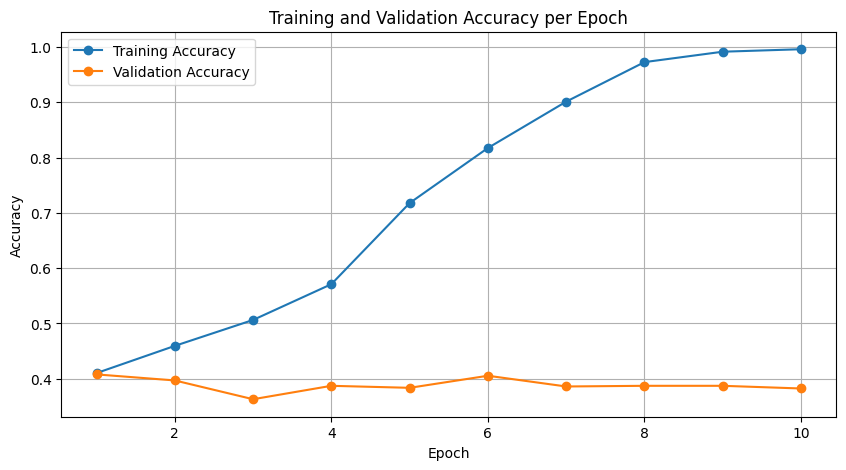

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracy values for each epoch
train_accuracies = []
val_accuracies = []

# Calculate accuracy for each epoch
for epoch in range(epochs):
    # Training accuracy
    correct_train = sum([pred == label for pred, label in zip(all_preds_train[epoch], all_labels_train[epoch])])
    total_train = len(all_labels_train[epoch])
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    correct_val = sum([pred == label for pred, label in zip(all_preds_val[epoch], all_labels_val[epoch])])
    total_val = len(all_labels_val[epoch])
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
epoch = 6
conf_matrix = confusion_matrix(all_labels_val[epoch-1], all_preds_val[epoch-1])
accuracy = accuracy_score(all_labels_val[epoch-1], all_preds_val[epoch-1])
labels = ['0', '1', '2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, linewidths=1, linecolor='black')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ViT Model Confusion Matrix   acc='+str(round(100*accuracy,2))+'%')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [ ]:
#disconnect GPU to save compute units
os.system("kill -9 -1")